# Modül 1 :: Makine Öğrenmesine Giriş ve Proje Yaşam Döngüsü

## İçindekiler (Table of Contents)

1. Neden ML? Doğru Problem Çerçevesi
    - 1.1 Öğrenme Hedefleri — Açıklamalar ve Örnekler
    - 1.2 Problem Statement Canvas

2. Uçtan Uca ML Yaşam Döngüsü (CRISP‑DM + MLOps)

3. Başarı Metrikleri ve Kabul Kriterleri
    - Dolandırıcılık Tespiti (Fraud Detection)
    - Öneri Sistemleri (Recommendation Systems)
    - Talep Tahmini (Demand Forecasting)
    - Kabul Kriteri Şablonu
    - Mini Metrik Oyun Alanı

4. Veri Hazırlık Seviyeleri ve Veri Sözleşmeleri
    - Seviyelerin Detaylı Açıklaması
    - Veri Sözleşmesi

5. Doğrulama Stratejileri
    - Stratejilerin Detaylı Analizi

6. Baseline (Temel) Modeller

7. Deney Kaydı ve Sürümleme

8. Deployment Giriş: Batch vs Gerçek Zamanlı
    - Modeli Riske Atmadan Canlıya Alma
    - Başarıyı Ölçmek: SLO

9. İzleme ve Geri Besleme
    - Ne İzlemeliyiz?
    - Alarm Kuralları
    - MLOps Feedback Loop

10. Risk Kaydı

11. Proje İskeleti ve Dosya Düzeni


## 0. Ortam Bilgisi ve Kurulum

In [ ]:
# !pip install --upgrade scikit-learn

In [ ]:
import json
import pathlib
import platform
import random
import sys
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

print("Python :", sys.version.split()[0])
print("Platform:", platform.platform())
print("NumPy  :", np.__version__)
print("Pandas :", pd.__version__)

Python : 3.11.13
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
NumPy  : 2.0.2
Pandas : 2.2.2


## 1. Neden ML? Doğru Problem Çerçevesi

Makine öğrenmesi, **ölçülebilir değer** ürettiğinde anlamlıdır: bir metriği iyileştirmek, bir maliyeti azaltmak veya riski kontrol etmek. Başlangıçta çözüm değil, **problem çerçevesi** netleştirilir.

### 1.1. Öğrenme Hedefleri — Açıklamalar ve Örnekler
- **İş problemini ölçülebilir ML problemine çevirmek:** “Sepet terkini azaltmak” → “7 gün içinde satın alma olasılığını tahminle (0/1)”. *SaaS churn* örneği: 30 gün içinde iptal riski skoru üret, %80+ skorları retansiyon kampanyasına sok.
- **Başarı metrikleri ve kabul kriterleri:** Ana metrik + guardrail’ler. Örn. *AUC ≥ 0.78; p95 gecikme < 50 ms; aylık maliyet < 3.000$*. *Fraud*’da **Recall** kritik; yanlış alarm tavanı gerekir.
- **Veri toplama, sözleşmeler ve hazırlık seviyeleri:** Kaynak → Şema → Tazelik → Eksik değer → PII → Sürüm. “R0→R3” olgunluk adımları ile netleşir.
- **Kaçınılması gereken hatalar:** *Veri sızıntısı* (geleceği görme), *yanlış doğrulama* (zaman serisinde rastgele split), *hatalı baseline* (referanssız kıyas).
- **Basit deney kaydı, sürümleme ve teslim:** Deney ID, veri/özellik/kod versiyonu, hiperparametre, metrik, model artefaktı. Örn. `2025-07-29_fraud_v12_svc`.

### 1.2. Problem Statement Canvas

In [ ]:
canvas = pd.DataFrame([
    ["İş Amacı", "İş değeri", "Sepet terkini %10 azalt"],
    ["ML Görevi", "Sınıflandırma/Regresyon/Sıralama/Anomali", "7 günde satın alma (0/1)"],
    ["Hedef (y)", "Etiket tanımı", "purchase_within_7d"],
    ["Ana Metrik", "İş karşılığı olan ölçüt", "AUC/F1 (dengesiz veri)"],
    ["Kabul Kriteri", "Başarı eşiği", "AUC ≥ 0.78 & p95 < 50ms"],
    ["Guardrails", "Güvenlik şeritleri", "Fairness, maliyet, gecikme"],
    ["Kullanım", "Çıktı aksiyonu", "Skor > 0.8 → kampanya"],
    ["Çevrim", "Batch/online & tazelik", "15 dakikada bir skor"],
    ["Kısıtlar", "PII/SLA/mevzuat", "KVKK/GDPR"],
    ["Paydaşlar", "Roller", "Ürün, Veri, Müh., Hukuk"],
    ["Riskler", "Erken uyarılar", "Sızıntı, drift, etiket gürültüsü"],
], columns=["Alan", "Açıklama", "İpucu/Örnek"])

display(canvas.style.set_properties(**{"text-align": "left"}).hide(axis="index"))

Alan,Açıklama,İpucu/Örnek
İş Amacı,İş değeri,Sepet terkini %10 azalt
ML Görevi,Sınıflandırma/Regresyon/Sıralama/Anomali,7 günde satın alma (0/1)
Hedef (y),Etiket tanımı,purchase_within_7d
Ana Metrik,İş karşılığı olan ölçüt,AUC/F1 (dengesiz veri)
Kabul Kriteri,Başarı eşiği,AUC ≥ 0.78 & p95 < 50ms
Guardrails,Güvenlik şeritleri,"Fairness, maliyet, gecikme"
Kullanım,Çıktı aksiyonu,Skor > 0.8 → kampanya
Çevrim,Batch/online & tazelik,15 dakikada bir skor
Kısıtlar,PII/SLA/mevzuat,KVKK/GDPR
Paydaşlar,Roller,"Ürün, Veri, Müh., Hukuk"


## 2. Uçtan Uca ML Yaşam Döngüsü (CRISP‑DM + MLOps)

Aşamalar **geri besleme** ile tekrarlanır; her aşamanın *çıktı artefaktı* teslimi kaliteyi artırır.
- **İş Anlayışı:** Kapsam, metrik, kabul kriteri → *Problem Canvas*.
- **Veri Anlayışı & Hazırlık:** Kaynak/şema/tazelik → *Veri sözleşmesi, kalite raporu*.
- **Modelleme:** Önce baseline → *Eğitim script’i, model artefaktı*.
- **Değerlendirme:** Doğru CV, hata analizi, adalet → *Değerlendirme raporu, model kartı*.
- **Yayınlama:** Batch/online; kaynak, gecikme, maliyet → *Servis/akış diyagramı*.
- **İzleme:** Performans, drift, fairness → *Alarm kuralları, dashboard*.
- **Süreklilik:** Deney kaydı, sürümleme, rollback → *Sürümleme tablosu*.

## 3. Başarı Metrikleri ve Kabul Kriterleri

Bazı sınıflandırma metrikleri:
$$
\text{Precision} = \frac{TP}{TP+FP},\qquad
\text{Recall} = \frac{TP}{TP+FN},\qquad
F_1 = 2\cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision}+\text{Recall}}
$$

<br><br>

Regresyon için bazı metrikler:

$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2},\qquad$
$\text{MAE} = \frac{1}{n} \sum_{i=1}^n |\hat{y}_i - y_i|$

### Dolandırıcılık Tespiti (Fraud Detection)

**Ana Fikir:** `Recall` (Duyarlılık) metriği en üst düzeye çıkarılırken, `False Positive` (Yanlış Pozitif) sayısı operasyonel kapasite ile sınırlandırılır.

**Neden Bu Yaklaşım Seçilir?**
Bu senaryoda, bir dolandırıcılık vakasını kaçırmanın (`False Negative`) maliyeti, normal bir işlemi yanlışlıkla "dolandırıcılık" olarak işaretlemenin (`False Positive`) maliyetinden çok daha yüksektir. Kaçırılan her dolandırıcılık vakası doğrudan finansal kayıp ve müşteri güveninin sarsılması anlamına gelir. Yanlış alarm ise genellikle bir müşteri hizmetleri araması veya manuel bir inceleme ile çözülebilir, bu da daha düşük bir maliyettir.

**Detaylı Açıklama:**
*   **Recall (Duyarlılık):** Gerçek dolandırıcılık vakalarının ne kadarını doğru bir şekilde tespit edebildiğimizi ölçer. Formülü: `Recall = TP / (TP + FN)`'dir. (TP: Gerçek Pozitif, FN: Yanlış Negatif). Hedefimiz, hiçbir dolandırıcılığı kaçırmamak olduğu için Recall'ı mümkün olduğunca %100'e yaklaştırmaktır.
*   **False Positive (Yanlış Pozitif):** Modelin, aslında normal olan bir işlemi "dolandırıcılık" olarak etiketlemesidir. Recall'ı artırmak için modelin hassasiyetini yükselttiğimizde, genellikle False Positive sayısı da artar.
*   **Operasyonel Tavan:** Bir şirketin dolandırıcılık inceleme ekibinin günlük olarak bakabileceği vaka sayısı sınırlıdır. Örneğin, bir ekip günde en fazla 500 şüpheli işlemi inceleyebiliyorsa, modelin günde 500'den fazla False Positive üretmesi operasyonel bir kaosa yol açar. Bu nedenle, modelin karar eşiği (threshold) ayarlanırken, Recall mümkün olan en yüksek seviyede tutulur ancak False Positive sayısı operasyonel ekibin kapasitesini aşmayacak bir seviyede sabitlenir. İş birimleri ve veri bilimi ekibi arasında bir denge kurmayı gerektirir.

---

### Öneri Sistemleri (Recommendation Systems)

**Ana Fikir:** Çevrimdışı (offline) testlerde `NDCG@K` gibi metriklerdeki artış, çevrimiçi (online) ortamda `CTR` (Tıklama Oranı) gibi iş metriklerinde artışı garanti etmez. Bu nedenle, modeller mutlaka A/B testleri ile ve `guardrail` (koruyucu) metrikler izlenerek canlıya alınmalıdır.

**Neden Bu Yaklaşım Seçilir?**
Çevrimdışı metrikler, statik bir veri kümesi üzerinde modelin sıralama kalitesini ölçer ve hızlı geri bildirim sağlarlar. Ancak gerçek kullanıcı davranışını, arayüzün etkisini (UI/UX), gecikmeyi (latency) ve keşif (serendipity) gibi faktörleri yansıtamazlar. Bir modelin iş hedeflerine gerçekten hizmet edip etmediğini anlamanın tek kesin yolu, onu gerçek kullanıcılarla test etmektir.

**Detaylı Açıklama:**
*   **Offline Metrik (NDCG@K):** *Normalized Discounted Cumulative Gain at K*, öneri listesinin ilk K pozisyonunun doğruluğunu ve sıralama kalitesini ölçer. En alakalı ürünlerin listenin en başında yer almasını daha yüksek puanlandırır. Model geliştirme aşamasında çok kullanışlı bir proxy metriktir.
*   **Online Metrik (CTR, Conversion):** Kullanıcıların önerilere gerçekten tıklayıp tıklamadığını (`CTR`) veya bir satın alma/etkileşim gerçekleştirip gerçekleştirmediğini (`Conversion Rate`) ölçer. Bunlar, sistemin iş değerini doğrudan yansıtan metriklerdir.
*   **Neden Garanti Yoktur?:** Çevrimdışı testte "alaka düzeyi" yüksek olarak etiketlenmiş bir ürün, canlı ortamda kötü bir resim, yüksek fiyat veya kullanıcının o anki ruh hali nedeniyle tıklama almayabilir. Çevrimdışı veri, bu dinamik bağlamı yakalayamaz.
*   **Guardrail (Koruyucu) Metrikler:** A/B testi sırasında sadece ana hedef metriğe (örn. CTR) odaklanmak tehlikeli olabilir. Yeni model CTR'ı artırırken, belki de öneri çeşitliliğini azaltıyor, uzun kuyruk (long-tail) ürünlerin satışını düşürüyor veya sayfa yüklenme süresini artırıyor olabilir. İşte bu gibi istenmeyen yan etkileri tespit etmek için izlenen ek metriklere `guardrail` denir. Örneğin, "kullanıcı başına gelir", "sepetten ayrılma oranı", "öneri çeşitliliği" gibi metrikler guardrail olarak kullanılabilir.

---


### Talep Tahmini (Demand Forecasting)

**Ana Fikir:** Tahmin hatasının maliyeti simetrik değilse (yani eksik tahmin ile fazla tahminin maliyetleri farklıysa), standart `MSE` (Ortalama Kare Hata) yerine `Quantile Loss` (Kantil Kaybı) veya `MAE` (Ortalama Mutlak Hata) gibi kayıp fonksiyonları tercih edilebilir.

**Neden Bu Yaklaşım Seçilir?**
Klasik regresyon modelleri genellikle hatanın büyüklüğünü önemser, yönünü değil. Ancak iş dünyasında sonuçlar farklıdır:
*   **Eksik Tahmin (Under-prediction):** Rafların boş kalması, satış fırsatlarının kaçırılması ve müşteri memnuniyetsizliği demektir. Bu özellikle yüksek kâr marjlı ürünlerde çok maliyetlidir.
*   **Fazla Tahmin (Over-prediction):** Fazla stok, depolama maliyetleri, sermayenin boşa bağlanması ve özellikle taze ürünler için bozulma/çöp olma riski anlamına gelir.

Bu iki hatanın maliyeti eşit olmadığında, modeli daha pahalı olan hatayı yapmaktan caydıracak bir kayıp fonksiyonu kullanmak mantıklıdır.

**Detaylı Açıklama:**
*   **MAE (Ortalama Mutlak Hata):** `MAE = (1/n) * Σ|y_gerçek - y_tahmin|`. MSE'ye göre aykırı değerlere karşı daha dayanıklıdır ve hataları simetrik olarak (yönüne bakmaksızın) cezalandırır. Maliyetlerin simetrik olduğu veya aykırı değerlerin etkisinin azaltılmak istendiği durumlarda iyi bir başlangıç noktasıdır.
*   **Quantile Loss (Kantil Kaybı):** Asimetrik maliyetler için en ideal çözümdür. Bu kayıp fonksiyonu, bir `τ` (tau) parametresi alır (0 ile 1 arasında).
    *   Eğer **eksik tahmin** çok maliyetliyse (satış kaçırmak istemiyorsak), `τ` değeri yüksek seçilir (örn. `τ = 0.90`). Bu durumda model, gerçek değerin altında kalan tahminler için çok daha büyük bir ceza öder ve sistematik olarak daha yüksek tahminler yapmaya yönlendirilir. Böylece stokta ürün bulundurma olasılığı artar.
    *   Eğer **fazla tahmin** çok maliyetliyse (stok maliyetinden kaçınmak istiyorsak), `τ` değeri düşük seçilir (örn. `τ = 0.20`). Bu durumda model, gerçek değerin üzerinde kalan tahminler için daha büyük ceza öder ve daha tutucu (düşük) tahminler yapmaya zorlanır.
    *   `τ = 0.50` seçildiğinde, Quantile Loss fonksiyonu `MAE`'ye eşdeğer hale gelir ve medyanı tahmin etmeye çalışır.

**Kabul Kriteri Şablonu**

Bir makine öğrenmesi modelinin "başarılı" sayılması için sadece çevrimdışı (offline) metriklerde iyi performans göstermesi yeterli değildir. Modelin canlı ortama (üretim/production) çıkabilmesi için teknik, finansal ve etik gereksinimleri de karşılaması gerekir. Aşağıdaki tablo, `Model v1.2` için belirlenen kabul kriterlerini ve her birinin ne anlama geldiğini detaylı bir şekilde açıklamaktadır.

---

### **Kabul Kriterleri: Model v1.2**

| **Kriter** | **Değer** | **Açıklama** | **Neden Önemli?** |
|:---:|:---:|:---|:---|
| **Performans (Offline)** | `AUC ≥ 0.80 ± 0.02`<br>*(5-fold CV)* | Modelin sınıfları ayırt etme yeteneğini ölçer.<br>**5-katlı Çapraz Doğrulama** ile<br>performansın genellenebilir olduğu<br>teyit edilir. | Modelin ezber yapmadığından<br>*(overfitting)* emin olmak ve<br>sınıf dengesizliğine karşı<br>güvenilir bir ölçüt kullanmak. |
| **Performans (Online)** | `p95 Latency`<br>`< 40ms` | İsteklerin %95'i **40ms altında** yanıtlanmalıdır.<br>**p95**, kullanıcıların çoğunluğunun<br>deneyimlediği en kötü senaryoyu<br>kontrol eder. | İyi bir **kullanıcı deneyimi**<br>sunmak ve sistemin yük altında<br>bile istikrarlı çalıştığını<br>garanti etmek. |
| **Maliyet** | `Günlük MLOps`<br>`Maliyeti < 100$` | Modelin çalışması için gereken<br>tüm altyapı (sunucu, izleme vb.)<br>maliyetlerinin toplamıdır. | Projenin **finansal olarak**<br>**sürdürülebilir** olmasını sağlamak<br>ve yatırım getirisini (ROI)<br>pozitif tutmak. |
| **Adillik (Fairness)** | `Gruplar arası`<br>`TPR farkı < 0.05` | Farklı demografik gruplar için<br>modelin pozitif vakaları<br>yakalama oranının (**TPR**)<br>benzer olmasıdır. | **Etik ve yasal riskleri** azaltmak.<br>Modelin belirli gruplara karşı<br>sistematik olarak **yanlı (biased)**<br>davranmasını engellemek. |


## 3 Mini Metrik Oyun Alanı

Metrik,Değer
Accuracy,0.990000
Precision,1.000000
Recall,0.167000
F1,0.286000


<Figure size 640x480 with 0 Axes>

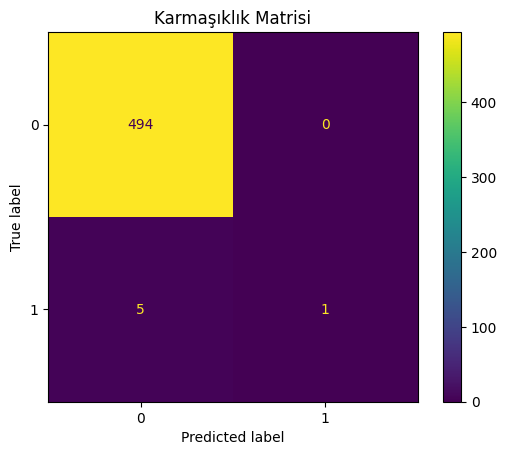

In [ ]:
"""
Gerçek hayat problemlerinin çoğu dengesizdir. Örneğin, kredi kartı işlemlerinde
dolandırıcılık tespiti yaparken, işlemlerin %99'u normal, sadece %1'i sahtedir.
Modelimizin bu nadir durumu ne kadar iyi yakaladığını ölçmek için dengesiz bir
veri seti oluşturalım.

`weights=[0.99, 0.01]` parametresi ile verimizin **%99'unun 0 (negatif) sınıfına**
**%1'inin ise 1 (pozitif) sınıfına** ait olmasını sağlıyoruz.
"""

X, y = make_classification(n_samples=2000,
                           n_features=10,
                           weights=[0.99, 0.01],
                           random_state=RANDOM_STATE)

"""
Modelimizin performansını objektif bir şekilde ölçebilmek için onu daha önce
hiç görmediği verilerle test etmeliyiz. Bu yüzden veri setimizi
eğitim (train) ve test (test) olarak ikiye ayırıyoruz.

stratify=y Parametresi: Eğitim ve test setlerindeki pozitif/negatif sınıf oranlarının,
orijinal veri setindeki oranla aynı kalmasını sağlar. Bu özellikle dengesiz verilerde
modelin doğru bir şekilde değerlendirilmesi için kritiktir.
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)

"""
Pipeline, veri ön işleme (StandardScaler) ve modelleme (LogisticRegression)
adımlarını birleştirerek kod tekrarını azaltır ve veri sızıntısını (data leakage) önler.
"""
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lr', LogisticRegression(max_iter=1000,
                                           random_state=RANDOM_STATE))])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

rows = [
    ("Accuracy", accuracy_score(y_test, pred)),
    ("Precision", precision_score(y_test, pred)),
    ("Recall", recall_score(y_test, pred)),
    ("F1", f1_score(y_test, pred)),
]
metric_df = pd.DataFrame(rows, columns=["Metrik", "Değer"]).round(3)
display(metric_df.style.hide(axis="index"))
cm = confusion_matrix(y_test, pred)
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(values_format='d')
plt.title("Karmaşıklık Matrisi")
plt.show()

Modelimizin ürettiği yeni sonuçlar, makine öğrenmesinde sıkça karşılaşılan ve dikkatle analiz edilmesi gereken bir durumu mükemmel bir şekilde özetliyor.

| Metrik | Değer |
|---|---|
| Accuracy | 0.990 |
| Precision | 1.000 |
| Recall | 0.167 |
| F1-Score | 0.286 |

---

*   **Accuracy (Doğruluk) - `%99.0`:** İlk bakışta modelimiz neredeyse mükemmel görünüyor. Tüm tahminlerin %99'unu doğru yapmış. Ancak dengesiz veri setlerinde bu metrik, bizi en çok yanıltan metriktir. Verinin büyük çoğunluğu negatif sınıfa ait olduğu için, model neredeyse her şeye "negatif" diyerek bile bu kadar yüksek bir doğruluk oranına ulaşabilir. **Bu metrik tek başına hiçbir anlam ifade etmiyor.**

*   **Precision (Kesinlik) - `1.0` (Mükemmel! (hihi)):** Bu sonuç, modelin "pozitif" olarak etiketlediği **hiçbir örnekte yanılmadığını** gösterir (`False Positive = 0`). Model ne zaman "Bu bir pozitif vakadır" dediyse, %100 haklı çıkmıştır. Modelin pozitif tahminler yaparken aşırı derecede "ihtiyatlı" ve "emin" davrandığını gösterir.

*   **Recall (Duyarlılık) - `0.167` (Çok Düşük!):** İşte modelin asıl zayıflığı burada yatıyor. Bu metrik bize, gerçekte pozitif olan vakaların **sadece %16.7'sini** yakalayabildiğini söylüyor. Diğer bir deyişle, modelimiz pozitif vakaların **%83.3'ünü gözden kaçırmıştır (`False Negative`)**.

*   **F1-Score - `0.286`:** Precision ve Recall metriklerinin harmonik ortalamasıdır. Recall değeri çok düşük olduğu için, mükemmel Precision'a rağmen F1 skoru da oldukça düşük kalmıştır. Bu durum, F1-Score'un modelin genel performansını Accuracy'den çok daha dürüst bir şekilde yansıttığını gösterir.

#### **Büyük Resim: Ne Anlama Geliyor?**

Bu modeli "aşırı temkinli" bir güvenlik görevlisine benzetilebiliriz. Sadece %100 emin olduğu kişileri içeri alıyor (mükemmel Precision), bu yüzden hiçbir yanlış kişiyi almıyor. Ancak bu katı kuralı yüzünden, aslında içeri girmesi gereken kişilerin büyük bir çoğunluğunu da kapı dışarı ediyor (çöp Recall).

**Bu model ne zaman KESİNLİKLE kullanılmaz?**
*   **Pozitif vakaları kaçırmanın maliyeti yüksek olduğunda.**
    *   **Hastalık Teşhisi:** Kanserli bir hastayı "sağlıklı" olarak etiketlemek (düşük recall) kabul edilemez.
    *   **Dolandırıcılık Tespiti:** Gerçekleşen dolandırıcılık işlemlerinin %83'ünü kaçırmak, şirketi iflasa sürükleyebilir.
    *   **Spam Tespiti:** Gelen kutunuza düşen önemli bir e-postanın (pozitif vaka) %83 ihtimalle spam klasörüne gitmesi felaket olurdu.

In [ ]:
try:
    import ipywidgets as widgets
    from ipywidgets import interact
except ImportError:
    print("Lütfen 'ipywidgets' kütüphanesini yükleyin: !pip install ipywidgets")
    widgets = None

if widgets:
    pred_proba = pipe.predict_proba(X_test)[:, 1]

    @interact(threshold=widgets.FloatSlider(min=0.05, max=0.95, step=0.05, value=0.5,
                                            description="Karar Eşiği:"))
    def update_metrics(threshold):
        new_pred = (pred_proba >= threshold).astype(int)

        rows = [
            ("Accuracy", accuracy_score(y_test, new_pred)),
            ("Precision", precision_score(y_test, new_pred, zero_division=0)),
            ("Recall", recall_score(y_test, new_pred, zero_division=0)),
            ("F1-Score", f1_score(y_test, new_pred, zero_division=0)),
        ]
        metric_df_interactive = pd.DataFrame(rows, columns=["Metrik", "Değer"]).round(3)
        display(metric_df_interactive.style.hide(axis="index"))

        # Karmaşıklık Matrisini çizdir
        cm_interactive = confusion_matrix(y_test, new_pred)
        disp_interactive = ConfusionMatrixDisplay(confusion_matrix=cm_interactive,
                                                  display_labels=[0, 1])
        disp_interactive.plot(values_format='d', cmap='Blues')
        plt.title(f"Karmaşıklık Matrisi (Eşik={threshold:.2f})")
        plt.show()

interactive(children=(FloatSlider(value=0.5, description='Karar Eşiği:', max=0.95, min=0.05, step=0.05), Outpu…

## 4. Veri Hazırlık Seviyeleri ve Veri Sözleşmeleri

Makine öğrenmesinde "Garbage In, Garbage Out" (Çöp Girer, Çöp Çıkar) prensibi esastır. Modelimizin kalitesi, kullandığımız verinin kalitesiyle doğrudan ilişkilidir. Ancak "kaliteli veri" soyut bir kavramdır. Veri Hazırlık Seviyeleri (VHR), verinin ham halinden, kurumsal olarak yönetilen ve güvenilir bir varlığa dönüşümündeki aşamaları somutlaştıran bir çerçevedir.

---

### Veri Hazırlık Seviyeleri Özet Tablosu

| Seviye | Tanım | Kabul Ölçütü | Örnek |
|:---:|:---|:---|:---|
| **R0** | Ham, doğrulanmamış | Kaynak & erişim tanımlı | Ham clickstream logları, API'den anlık çekilen JSON |
| **R1** | Temizlenmiş / Etiketlenmiş | Eksik/aykırı değer politikası yazılı | `purchase_within_7d` gibi etiketler eklenmiş, temel temizlikten geçmiş tablo |
| **R2** | Modellemeye Hazır | Eğitim/Validasyon/Test split politikası var | **Feature store** tablosu, modele hazır son özellikler |
| **R3** | İzlenebilir / Belgeli | Şema, sürüm & SLA yayımlanmış | **Data catalog** kaydı, veri soyu (lineage) takibi yapılmış, versiyonlu veri seti |

---

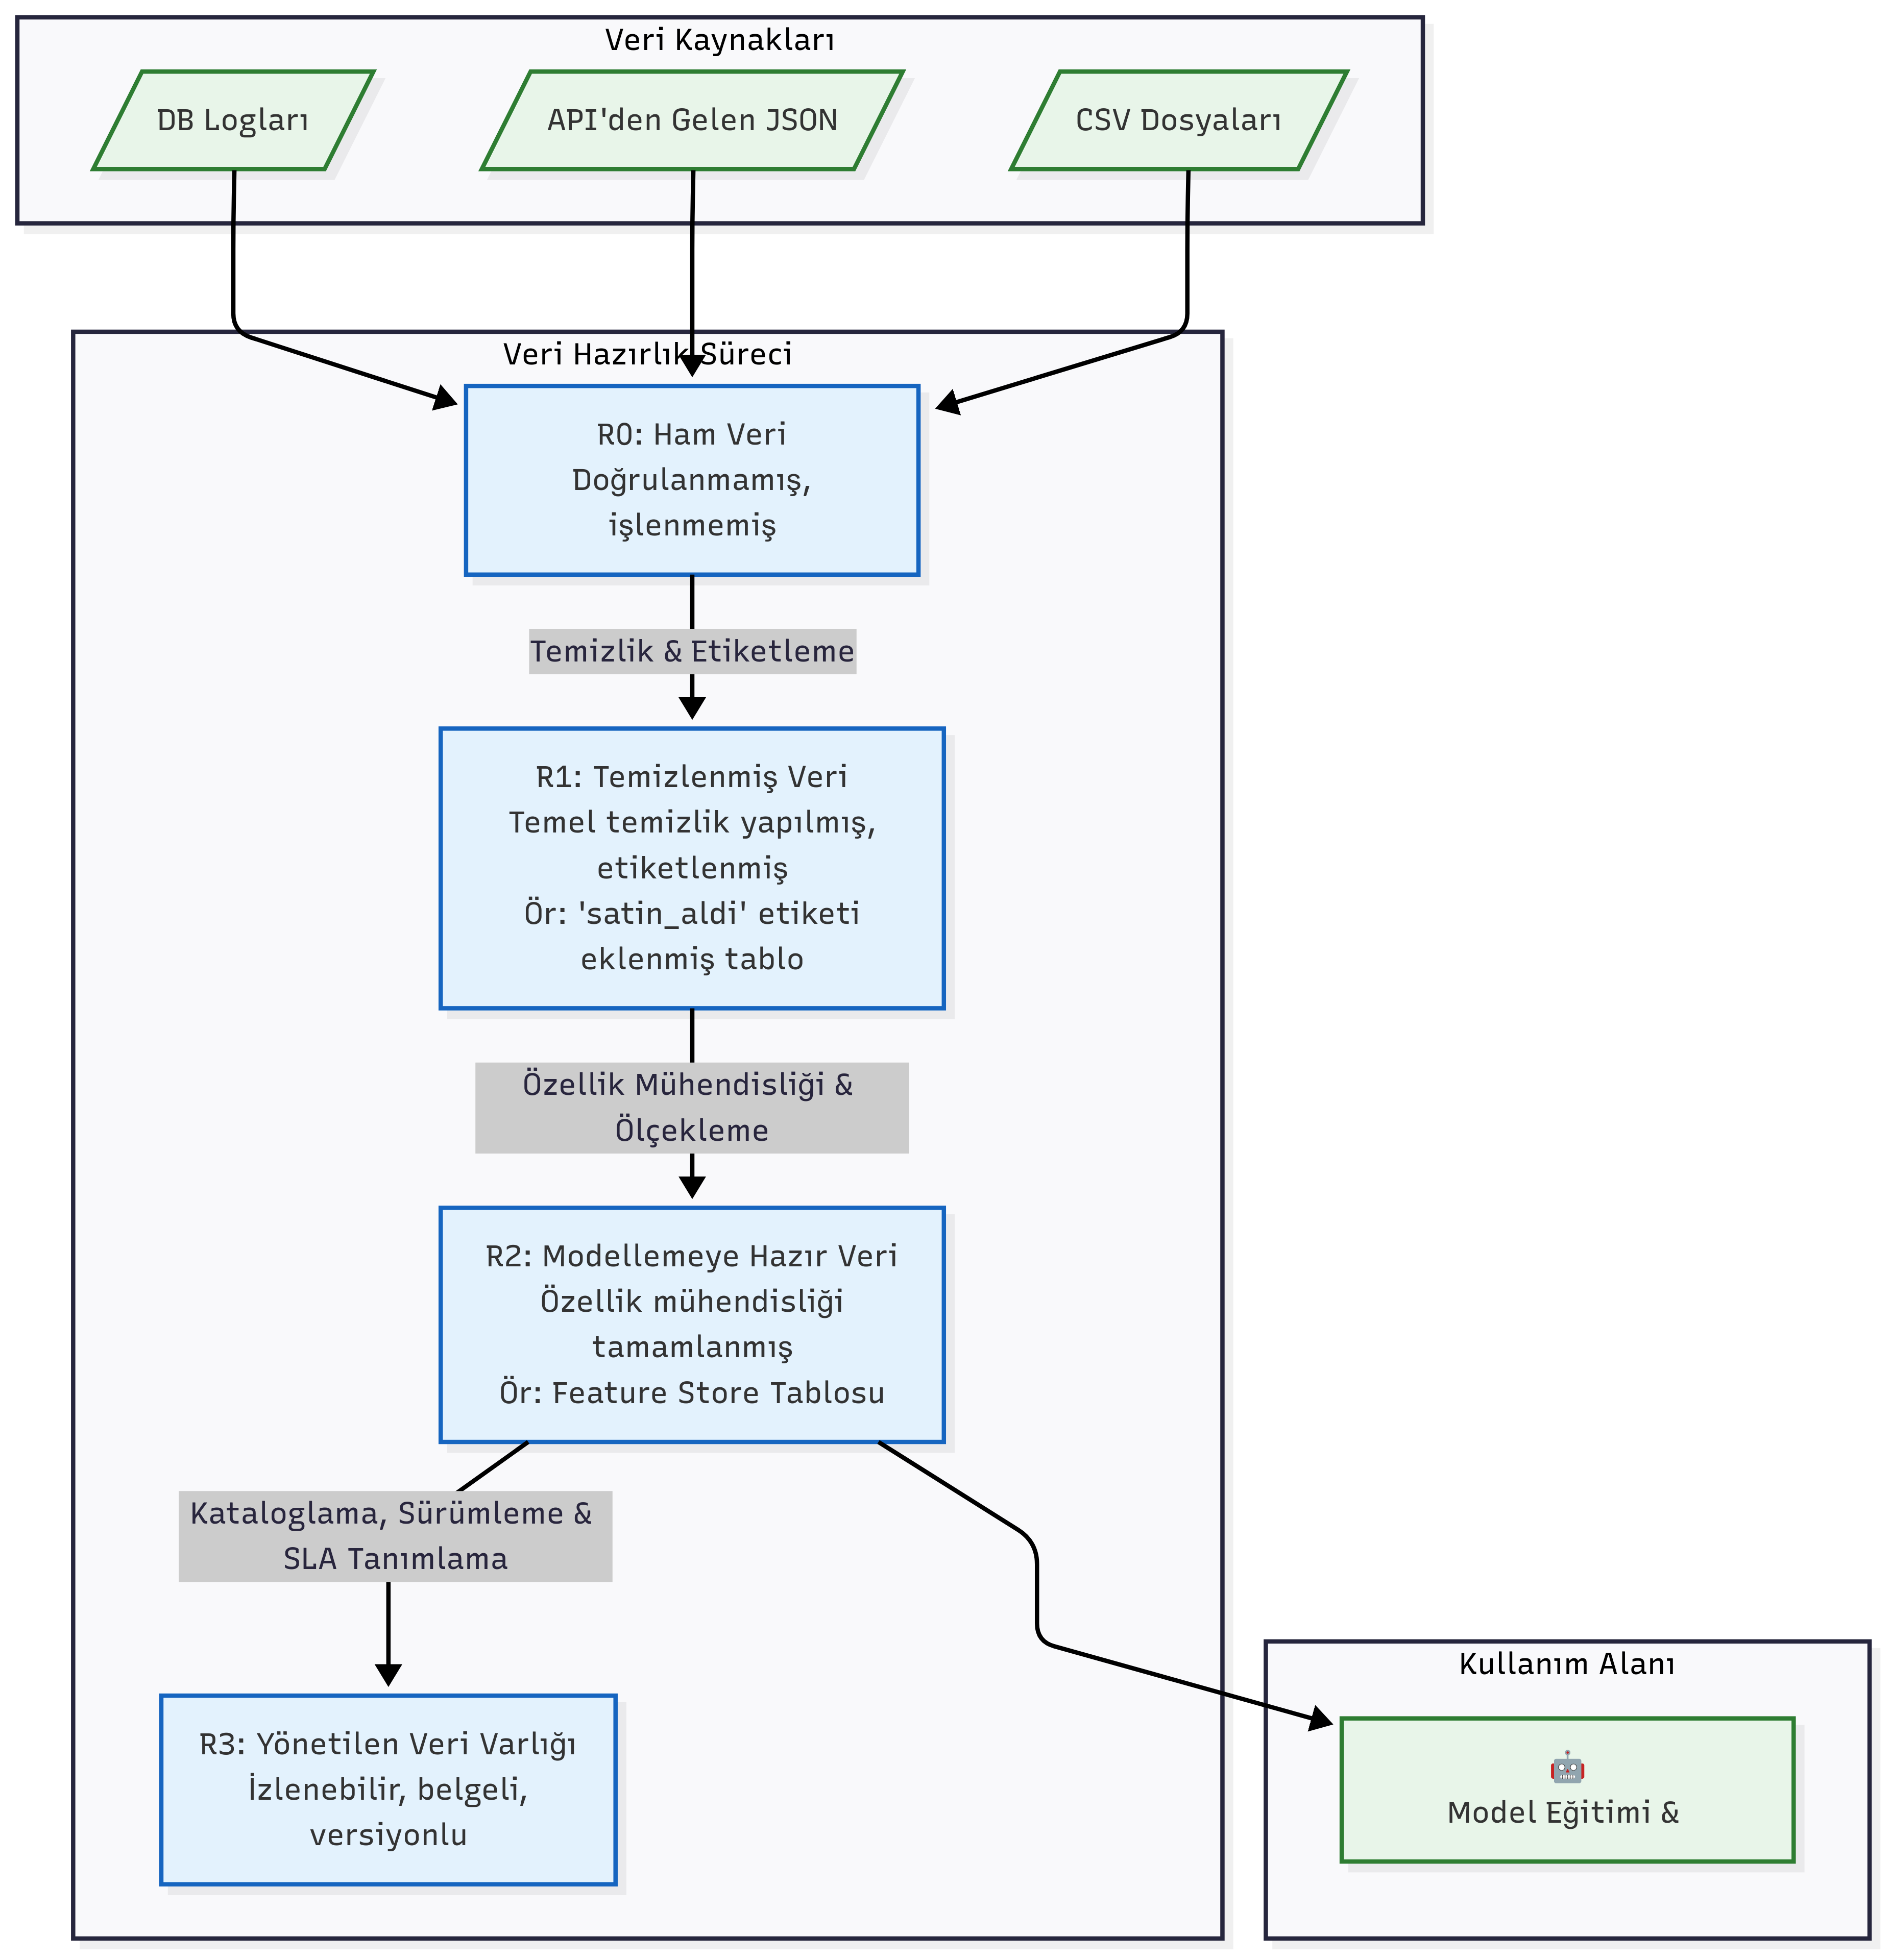

### Seviyelerin Detaylı Açıklaması

#### Seviye R0: Ham Veri (The Wild West)
*   **Tanım:** Verinin ilk elde edildiği, en ham ve işlenmemiş halidir. Veritabanı dökümleri, sensör logları, API yanıtları bu seviyededir.
*   **Amacı:** Veriyi elde etmek ve temel bir keşif analizi (EDA) yapmak. "Bu veride ne var?" sorusuna ilk cevabı aradığımız yerdir.
*   **Riskleri:**
    *   **Güvenilmezdir:** Duplike kayıtlar, veri tipi hataları (örn. sayı olması gereken yerde metin), eksik değerler ve tutarsızlıklar içerir.
    *   **Anlamsızdır:** Tek başına bir anlam ifade etmeyebilir. Örneğin bir `product_id`, ürünün adı veya kategorisi olmadan bir şey ifade etmez.
    *   **Doğrudan modellemede kullanmak, modelin tamamen yanlış öğrenmesine veya sürekli hata vermesine neden olur.**

---

#### Seviye R1: Temizlenmiş Veri (İlk Şekillendirme)
*   **Tanım:** R0 verisi üzerinde temel temizlik ve zenginleştirme adımlarının uygulandığı aşamadır.
*   **Amacı:** Ham veriyi, analiz ve modelleme için asgari düzeyde kullanılabilir hale getirmek.
*   **Yapılan İşlemler:**
    *   Aykırı değerler tespit edilir ve bir politika uygulanır.
    *   Veri tipleri düzeltilir.
    *   Hedef değişken (etiket) oluşturulur (örn. kullanıcı loglarından "satın alma yaptı/yapmadı" etiketi türetmek).
*   **Riskleri:** Veri artık daha temizdir ancak henüz tüm modelleme adımları için optimize edilmemiştir. Farklı modeller için farklı özellik mühendisliği adımları gerekebilir.

---

#### Seviye R2: Modellemeye Hazır Veri (Altın Standart)
*   **Tanım:** Veri bilimcilerin hayalindeki veridir. Tüm ön işleme ve özellik mühendisliği adımları tamamlanmış, `model.fit(X, y)` komutunu çalıştırmaya hazır haldeki veridir.
*   **Amacı:** Hızlı ve tekrarlanabilir model eğitimi sağlamak.
*   **Yapılan İşlemler:**
    *   Eksik değerler için bir strateji belirlenir (silme, ortalama ile doldurma vb.).
    *   Kategorik değişkenler `One-Hot Encoding` veya benzeri yöntemlerle sayısal hale getirilir.
    *   Özellikler ölçeklendirilir (`StandardScaler`, `MinMaxScaler`).
    *   Yeni özellikler türetilir (`feature engineering`).
    *   Bu hazır set, genellikle bir **Feature Store (Özellik Deposu)** üzerinde tutularak farklı modeller tarafından tekrar tekrar kullanılabilir.
*   **Riskleri:** Bu veri seti çok değerlidir ancak nasıl oluşturulduğu, hangi ham veriden geldiği belgelenmezse "büyülü bir tablo" olarak kalır. Zamanla güncelliğini yitirebilir veya yeniden üretilmesi zorlaşabilir.

---

#### Seviye R3: Yönetilen Veri
*   **Tanım:** R2 verisinin sadece modellemeye hazır olmakla kalmayıp, aynı zamanda tamamen yönetilen, belgelenmiş ve güvenilir bir kurumsal varlığa dönüştüğü nihai aşamadır.
*   **Amacı:** Veriyi kişilere veya projelere bağımlı olmaktan çıkarıp, kurum genelinde güvenilir ve sürdürülebilir bir şekilde kullanılmasını sağlamak.
*   **Yapılan İşlemler:**
    *   **Verinin Hikayesi (Data Lineage):** Bu verinin hangi R0 kaynağından, hangi R1 ve R2 adımlarından geçerek oluştuğu kayıt altına alınır.
    *   **Veri Kataloğu (Data Catalog):** Verinin şeması (kolonlar ve tipleri), açıklamaları, sahibi ve tazelik durumu gibi üst verileri (metadata) herkesin erişebileceği bir yerde yayımlanır.
    *   **SLA (Service Level Agreement):** Verinin ne sıklıkla güncelleneceği ve ne kadar taze olacağı garanti altına alınır.
    *   **Sürümleme (Versioning):** Veri setindeki veya üretim mantığındaki değişiklikler (DVC veya Git LFS gibi araçlarla) versiyonlanır.
*   **Sonuç:** Birisi "Bu 'churn_prediction_v3' tablosundaki 'recency' kolonu tam olarak ne anlama geliyor ve ne kadar güncel?" diye sorduğunda, cevap bir e-posta veya kişisel bilgiye değil, herkesin erişebileceği bir dokümantasyona dayanır. MLOps'un temel hedeflerinden biridir.

### Veri Sözleşmesi (Contract Olarak da Geçer)

Bir ML modeli veya bir analitik raporu, bir "veri tüketicisidir" (data consumer). Bu tüketicinin beslendiği veriyi üreten sistemler ise "veri üreticileridir" (data producers). Veri Sözleşmesi, üretici ile tüketici arasında yapılan, verinin yapısını, kalitesini ve servis seviyesini garanti altına alan bir anlaşmadır.

Tıpkı bir API sözleşmesinin yazılım bileşenlerinin birbirleriyle nasıl konuşacağını tanımlaması gibi `Veri Sözleşmesi` de veri akışının istikrarını ve güvenilirliğini sağlar. Amacı:
 * **Veri üreticisindeki bir değişikliğin, habersiz bir şekilde veri tüketicisi olan ML modelini bozmasını engellemektir.**

---

#### Bir Veri Sözleşmesinin Temel İçerikleri

Bir veri sözleşmesi genellikle aşağıdaki bileşenleri içeren bir konfigürasyon dosyası (örn: YAML) veya bir belge olarak tutulur.

| Kategori | Bileşen | Açıklama | Neden Kritik? | Örnek |
|:---:|:---:|:---|:---|:---|
| **Temel<br>Bilgiler** | **Sözleşme<br>Sürümü** | Sözleşmenin kendisinin<br>versiyon numarası. | Değişikliklerin takibini sağlar.<br>Tüketiciler hangi versiyona<br>bağımlı olduklarını bilirler. | `version: 2.1.0` |
| | **Sahiplik<br>(Ownership)** | Veri setini üreten ve<br>sözleşmeden sorumlu olan<br>ekip veya kişi. | Bir sorun olduğunda kiminle<br>iletişime geçileceğini<br>netleştirir. | `owner: marketing-analytics-team` |
| **Şema<br>(Schema)** | **Sütun Adları<br>ve Sırası** | Veri setinde bulunması garanti<br>edilen sütunların tam adları<br>ve sıraları. | Sütun adının değişmesi veya<br>silinmesi, en yaygın model<br>bozulma nedenidir. | `name: string, age: int,<br>signup_date: timestamp` |
| | **Veri<br>Tipleri** | Her bir sütunun beklenen<br>veri tipi (string, integer, float,<br>boolean, timestamp vb.). | Yanlış veri tipi (örn. `age`<br>sütununa "Yirmi" yazılması)<br>modeli doğrudan çökertir. | `age` sütunu `integer`<br>olmalıdır. |
| | **Null<br>Olabilirlik** | Hangi sütunların boş<br>(`NULL` veya `NaN`) değer<br>içerip içeremeyeceği. | Model veya Pipeline boş olmaması gereken<br>bir özellikte (`feature`) boş<br>değerle karşılaşırsa hata verir. | `user_id` `NOT NULL`<br>olmalıdır. |
| **Kalite &<br>Semantik** | **Değer<br>Aralığı** | Sayısal bir sütunun alabileceği<br>makul minimum ve maksimum<br>değerler. | Aykırı değerleri (örn. `age: 200`)<br>kaynağında tespit etmeyi sağlar. | `age` sütunu `0` ile `120`<br>arasında olmalıdır. |
| | **Kabul Edilen<br>Değerler** | Kategorik bir sütunun<br>alabileceği geçerli<br>değerlerin listesi. | Beklenmeyen bir kategori (örn.<br>`country: "USA"` yerine `"US"`)<br>modelin yanlış çalışmasına neden olur. | `payment_method`: `['credit_card',<br>'paypal', 'bank_transfer']` |
| | **Veri Tazeliği<br>(SLA)** | Verinin ne kadar güncel<br>olduğunun ve ne sıklıkla<br>yenilendiğinin garantisi. | Zaman serisi modelleri veya<br>anlık karar sistemleri için<br>hayati önem taşır. | "Veri her saat başı güncellenir<br>ve en fazla 65 dakika<br>gecikebilir." |
| **Operasyonel** | **Değişim<br>Yönetimi** | Sözleşmeyi ihlal edecek bir<br>değişiklik (breaking change)<br>yapılacağı zaman izlenecek prosedür. | Tüketicilere yeni versiyona<br>geçmeleri için zaman tanır<br>ve kaos yaşanmasını önler. | "Geriye uyumsuz değişiklikler<br>2 hafta önceden e-posta ile<br>duyurulur." |

---

### Örnek: YAML Formatında Veri Sözleşmesi

Aşağıda `user_features_v2` adlı bir tablo için oluşturulmuş basit bir veri sözleşmesi örneği bulunmaktadır.

```yaml
# user_features tablosunun 2. versiyonu için veri sözleşmesi
version: 2.0.1
owner: user-profile-service-team
description: "Kullanıcıların temel demografik ve aktivite özelliklerini içeren tablo."

schema:
  - name: user_id
    type: integer
    nullable: false
    unique: true
  - name: user_segment
    type: string
    nullable: false
    accepted_values: ['new', 'active', 'lapsed', 'churned']
  - name: age
    type: integer
    nullable: true
    value_range:
  - name: last_seen_days_ago
    type: integer
    nullable: false

quality_checks:
  freshness_sla:
    interval: 24 # hours
    max_delay: 2 # hours
  row_count:
    min: 10000

change_management:
  notification_channel: "#data-contracts-alerts"
  breaking_change_policy: "2-week notice via email"


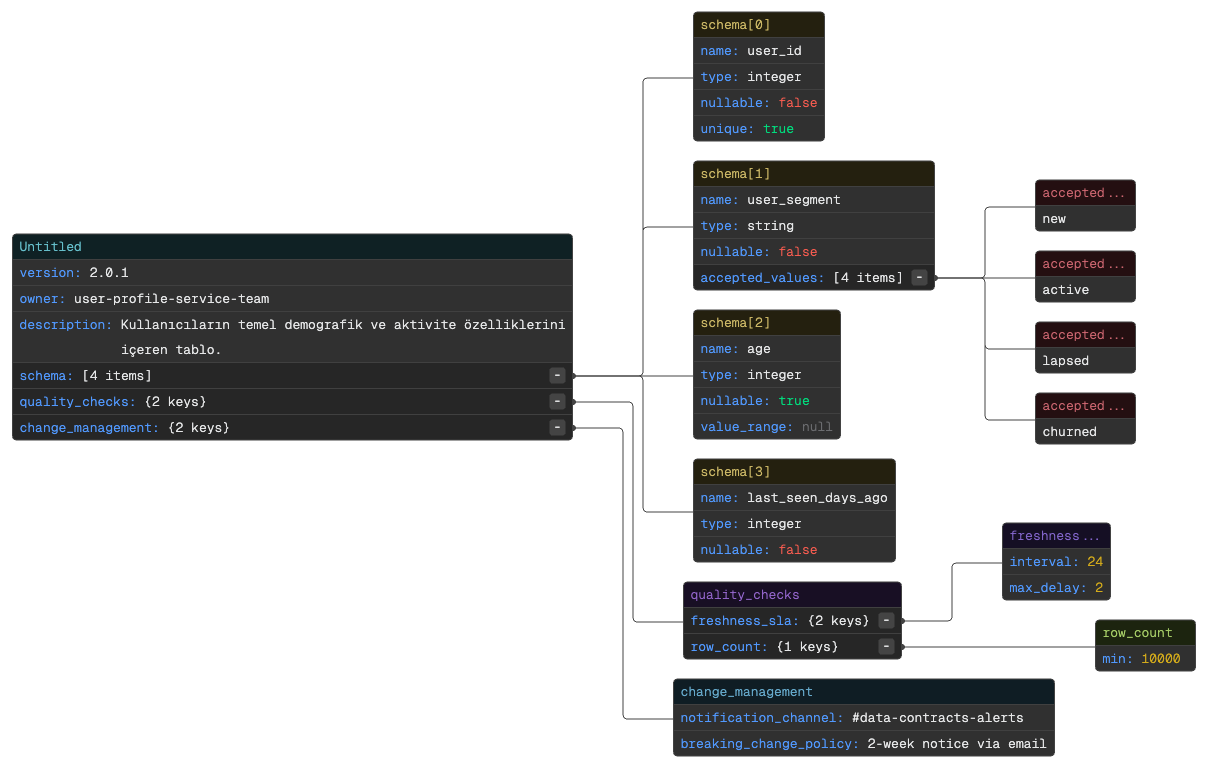

## 5. Doğrulama Stratejileri

Bir makine öğrenmesi modelinin gerçek dünya performansını tahmin etmek için onu daha önce görmediği verilerle test etmemiz gerekir. Çapraz doğrulama (Cross-Validation), veri setimizi akıllıca bölerek bu süreci defalarca simüle etmemizi ve böylece model performansı hakkında daha sağlam bir fikir edinmemizi sağlar.

Ancak verinin yapısı, hangi çapraz doğrulama stratejisinin uygun olduğunu belirler. Yanlış strateji seçimi, model performansı hakkında tamamen yanıltıcı sonuçlara yol açabilir.

---

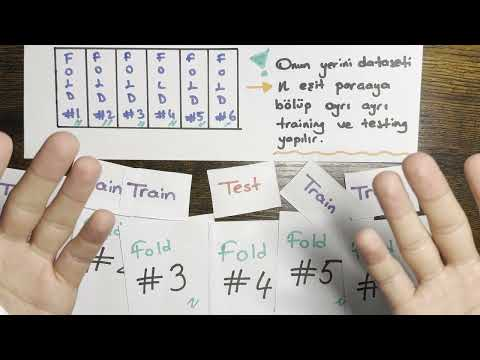

In [ ]:
# @title #### Mantığı Nedir?
from IPython.display import YouTubeVideo
YouTubeVideo('dt5PIECS8B0', width=800, height=450)

| Strateji | Temel Fikir | Ne Zaman Kullanılır? | Çözdüğü Ana Problem |
|:---:|:---|:---|:---|
| **Stratified K-Fold** | Sınıf oranlarını koru | Dengesiz (imbalanced) sınıflara sahip veri setleri | Azınlık sınıfının bir validasyon setinde hiç yer almaması riskini ortadan kaldırır. |
| **Group K-Fold** | Grupları asla bölme | Veri noktalarının bağımsız olmadığı durumlar (aynı kullanıcıya ait çoklu kayıtlar) | Modelin kişiyi/grubu ezberlemesini engelleyerek veri sızıntısını (data leakage) önler. |
| **TimeSeriesSplit** | Geçmişi kullanarak geleceği tahmin et | Zaman sıralı veriler (stok fiyatları, sensör verileri) | Gelecekteki veriyi kullanarak geçmişi tahmin etme mantıksızlığını (zamansal sızıntı) engeller. |
| **Leave-One-Group-Out** | "Bir grubu dışarıda bırak" | Modelin tamamen yeni bir gruba genelleme yeteneğini test etmek | Modelin belirli gruplara özel mi yoksa genel kuralları mı öğrendiğini test eder. |

---

### Stratejilerin Detaylı Analizi

#### 1. Stratified K-Fold: Dengesiz Sınıfların Koruyucusu

*   **Problem:** Standart `K-Fold`, veriyi tamamen rastgele böler. Eğer veri setinizde %95 "A" sınıfı ve %5 "B" sınıfı (azınlık sınıf) varsa, rastgele bir katmanın (fold) içine hiç "B" sınıfı örneği düşmeme ihtimali vardır. Bu durumda o katman için yapılan validasyonda modelin azınlık sınıfı performansı ölçülemez.
*   **Çözüm:** `StratifiedKFold`, veri setini katmanlara bölerken, her bir katmanın orijinal veri setindeki sınıf oranlarını (%95'e %5 gibi) korumasını garanti eder.
*   **Analoji: Meyve Salatası Yapmak**
    > Büyük bir kapta %95 elma ve %5 nadir bulunan çilek var. Bu kaptan rastgele 5 küçük kase salata (fold) yaparsanız, bazı kaselere hiç çilek düşmeyebilir. **Stratified K-Fold**, her bir küçük kaseye bilinçli olarak %95 elma ve %5 çilek koyarak her kasenin ana kabı temsil etmesini sağlamak gibidir.

#### 2. Group K-Fold: Bağımlılıkları Yönetmek

*   **Problem:** Bazen veri noktaları birbirinden bağımsız değildir. Örneğin, bir kullanıcının birden çok alışverişi, bir hastanın birden çok tahlil sonucu olabilir. Eğer bu kullanıcının verilerinin bir kısmı eğitim setine, bir kısmı da test setine düşerse **veri sızıntısı** olur. Model, genel satın alma davranışını öğrenmek yerine, o spesifik kullanıcıyı "ezberler" ve test setinde yapay olarak yüksek bir başarı gösterir.
*   **Çözüm:** `GroupKFold`, aynı gruba (örn. aynı `user_id`'ye) ait tüm veri noktalarının ya eğitim setinde ya da validasyon setinde olmasını sağlar. Bir grup asla ikiye bölünmez.
*   **Analoji: Hasta Teşhis Modeli**
    > Bir hastanenin, göğüs röntgenlerinden zatürre teşhisi koyan bir yapay zeka modeli geliştirdiğini düşünelim. Veri setinde 100 farklı hastadan alınmış toplam 500 röntgen filmi bulunsun. Her hasta (`patient_id`) bir "gruptur".
    >
    >**Yanlış Yaklaşım (Veri Sızıntısı):** Eğer standart bir doğrulama kullanırsak, aynı hastanın (örneğin, Ahmet Bey'in) Pazartesi çekilen röntgeni eğitim setine, Çarşamba çekilen röntgeni ise test setine düşebilir. Model, zatürrenin genel belirtilerini öğrenmek yerine, Ahmet Bey'in kaburga yapısını veya kalbinin özgün şeklini "ezberleyebilir". Test setindeki diğer röntgeni gördüğünde, "A, bu Ahmet Bey'in göğsü!" diyerek, hastalığı değil kişiyi tanıyarak doğru tahminde bulunur. Bu aslında yapay olarak şişirilmiş bir başarıdır ve modelin yeni bir hastada işe yaramayacağı (genellikle :)) anlamına gelir.
    >
    >**Doğru Yaklaşım (Group K-Fold):** `GroupKFold` ise bu sızıntıyı engeller. Ahmet Bey'in *tüm* röntgenlerini bir bütün olarak tutar. **Group K-Fold**, 99 hastanın tüm röntgenleriyle modeli eğitir ve daha önce hiç görmediği 100. hastanın (örneğin, Zeynep Hanım'ın) röntgenleriyle onu test eder. Bu işlemi her hasta için tekrarlar.
    >
    >**Asıl amaç**, modelin belirli hastaları ezberlemesi değil, genel olarak zatürre belirtilerini farklı insanlarda tanıma yeteneğini ölçmektir. Bu bize modelin gerçek bir klinikte yeni bir hastayla karşılaştığında ne kadar başarılı olacağını gösteren dürüst bir testtir.
---

#### 3. TimeSeriesSplit: Zamanın Akışına Saygı Duymak

*   **Problem:** Zaman serisi verilerinde (örn. hisse senedi fiyatları) temel bir kural vardır: Geleceği tahmin etmek için geçmişi kullanırsınız, asla tersi olmaz. Standart `K-Fold` veriyi karıştırır (shuffle), bu da modelin Salı günkü veriyi tahmin etmek için Perşembe günkü bilgiyi kullanmasına yol açar. Bu pratik olarak gerçek dünyada imkansızdır (zamanda yolculuk yapmıyorsanız tabi ki) ve performansı şişirir.
*   **Çözüm:** `TimeSeriesSplit` (veya "Walk-Forward Validation"), verinin zaman sıralamasını korur. Eğitim seti her zaman validasyon setinden önceki verilerden oluşur.
    *   **Fold 1:** Ocak verisiyle eğit -> Şubat verisini test et.
    *   **Fold 2:** Ocak+Şubat verisiyle eğit -> Mart verisini test et.
    *   **Fold 3:** Ocak+Şubat+Mart verisiyle eğit -> Nisan verisini test et.
*   **Analoji: Tarih Sınavına Çalışmak**
    > Bir tarih sınavına çalışırken, "Osmanlı'nın Kuruluş Dönemi" (geçmiş) hakkındaki soruları cevaplamak için "Lale Devri" (gelecek) bilginizi kullanamazsınız. Her zaman önceki konuları çalışarak bir sonraki konuyla ilgili soruları cevaplarsınız. **TimeSeriesSplit** tam olarak bu mantıkla çalışır.

---

#### 4. Leave-One-Group-Out (LOGO): En Zorlu Genelleme Testi

*   **Problem:** Modelimizin eğitime katılan gruplara mı özel çalıştığını, yoksa tamamen yeni bir grupla karşılaştığında da performans gösterebilecek kadar iyi genelleme yapıp yapmadığını nasıl anlarız?
*   **Çözüm:** `LeaveOneGroupOut`, `GroupKFold`'un en ekstrem halidir. Veri setindeki her bir grup için ayrı bir katman oluşturur. Her seferinde bir grubu validasyon için dışarıda bırakır ve kalan tüm gruplarla modeli eğitir.

## 6. Baseline (Temel) Modeller

Bir makine öğrenmesi projesine başladığımızda, ilk hedefimiz karmaşık bir model kurmak değil, **kuracağımız herhangi bir modelin neyi geçmesi gerektiğini** bilmektir. İşte bu "geçilmesi gereken en alt seviye" bizim **baseline (temel) modelimizdir**. Eğer geliştirdiğimiz süslü model, en basit ve en "aptalca" stratejiden daha iyi bir sonuç vermiyorsa, o zaman boşa kürek çekiyoruz demektir.

Bu bölümde, iki temel modeli karşılaştıracağız:
1.  **Çoğunluk Sınıfı (Dummy/Aptal Model):** Mümkün olan en basit strateji.
2.  **Lojistik Regresyon (Basit ML Modeli):** İlk makul makine öğrenmesi modelimiz.

---

### Adım 1: Veri Setinin Hazırlanması

İlk olarak, üzerinde çalışacağımız dengesiz bir veri seti oluşturalım. `weights=[0.7, 0.3]` parametresi ile verimizin %70'inin negatif (0), %30'unun ise pozitif (1) sınıftan oluşmasını sağlıyoruz.

```python
X, y = make_classification(...)
X_train, X_test, y_train, y_test = train_test_split(...)
```
---

### Adım 2: Baseline Modelin Hesaplanması (Çoğunluk Sınıfı)

Bu "dummy" modelimizdir. Stratejisi çok basittir:
 * **"Eğitim setindeki en sık görülen sınıf neyse, bütün tahminleri o olarak yap."**

Bu model, özelliklere (`X_test`) hiç bakmaz. Sadece etiketlerin (`y_train`) dağılımını kullanır:

* `pd.Series(y_train).mode()[0]`: Eğitim setindeki en sık tekrar eden sınıfı bulur (bizim durumumuzda bu '0' olacaktır).
* `np.full_like(y_test, ...)`: Test setindeki her bir örnek için bu "çoğunluk sınıfını" tahmin olarak içeren bir dizi oluşturur.
* `accuracy_score(...)`: Bu basit stratejinin doğruluk oranını hesaplar.

```python
majority = int(pd.Series(y_train).mode())
y_pred_majority = np.full_like(y_test, fill_value=majority)
acc_base = accuracy_score(y_test, y_pred_majority)
```

Bu stratejinin doğruluk oranının, veri setindeki çoğunluk sınıfının oranına (%70'e) çok yakın çıkmasını bekleriz.

### Adım 3: Sonuçların Karşılaştırılması ve Yorumlanması

Şimdi en önemli kısma geldik: iki modelin performansını karşılaştırmak. Farazi olarak şu sonuçları aldığımızı varsayalım:

| Model | Accuracy |
|---|---|
| Dummy Model | 0.69 |
| Lojistik Regresyon | 0.86 |

**Bu tablonun bize anlattığı hikaye şudur:**

1.  **Minimum Başarı Eşiğimiz `%69`'dur:** Eğer hiçbir şey yapmasak ve her tahmini "0" olarak verseydik, zaten yaklaşık %70 doğruluk oranına ulaşırdık. Bu bizim taban - baseline noktamızdır. Çoğunluk sınıfı baseline'ı, modelimizin bu "bedava" doğruluk oranını aşıp aşamadığını gösterir.

2.  **Modelimiz Anlamlı Bir Şey Öğreniyor:** Lojistik Regresyon modelimiz `%86`'luk bir doğruluk oranına ulaşmıştır. Bu skor baseline'dan yüksek. Bu durum modelimizin veri içindeki özellikleri (features) kullanarak, rastgele tahminden veya sadece çoğunluğa oynamaktan çok daha iyi bir iş çıkardığını gösterir. Modelimiz, sınıflar arasındaki ilişkiyi başarıyla öğrenmiştir.

**Sonuç:** Bir modelin performansı (örn. `%86` doğruluk) tek başına bir anlam ifade etmez. Bunun annlamı ancak ve ancak bir **baseline** ile karşılaştırıldığında ortaya çıkar. Bu karşılaştırma, projenin doğru yolda olup olmadığını gösteren ilk ve en önemli adımdır. Modelimiz baseline'ı geçtiğine göre, artık daha karmaşık modeller deneyerek veya özellik mühendisliği yaparak bu skoru daha da yukarı çekmeye çalışabiliriz.

In [ ]:
# @title #### Adım 3 - Kodu Çalıştırmak İsteyenler İçin
X, y = make_classification(n_samples=1200,
                           n_features=12,
                           weights=[0.7, 0.3],
                           random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)

majority = int(pd.Series(y_train).mode()[0])
y_pred_majority = np.full_like(y_test, fill_value=majority)
acc_base = accuracy_score(y_test, y_pred_majority)

pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
pipe.fit(X_train, y_train)
acc_lr = accuracy_score(y_test, pipe.predict(X_test))

baseline_comp = pd.DataFrame([
    ["Çoğunluk Sınıfı", acc_base],
    ["Lojistik Regresyon", acc_lr]
], columns=["Model","Accuracy"]).round(3)

display(baseline_comp.style.hide(axis="index"))

## 7. Deney Kaydı ve Sürümleme

In [ ]:
from pathlib import Path
def log_run(params: dict, metrics: dict, notes: str=""):
    run = {
        "ts": pd.Timestamp.utcnow().isoformat(),
        "params": json.dumps(params, ensure_ascii=False),
        "metrics": json.dumps(metrics, ensure_ascii=False),
        "notes": notes
    }
    csv = Path("runs/runs.csv")
    csv.parent.mkdir(exist_ok=True, parents=True)
    if csv.exists():
        df = pd.read_csv(csv)
        df = pd.concat([df, pd.DataFrame([run])], ignore_index=True)
    else:
        df = pd.DataFrame([run])
    df.to_csv(csv, index=False)
    return csv

params = {"model": "LogisticRegression", "max_iter": 1000, "scaler": "StandardScaler"}
metrics = {"accuracy": float(acc_lr)}
csv_path = log_run(params, metrics, notes="Deney kaydı örneği")
display(Markdown(f"**Kayıt yazıldı →** `{csv_path}`"))

display(pd.read_csv(csv_path).tail().style.hide(axis="index"))

**Kayıt yazıldı →** `runs/runs.csv`

ts,params,metrics,notes
2025-08-10T12:25:07.959407+00:00,"{""model"": ""LogisticRegression"", ""max_iter"": 1000, ""scaler"": ""StandardScaler""}","{""accuracy"": 0.8694444444444445}",Deney kaydı örneği


## 8. Deployment Giriş: Batch vs Gerçek Zamanlı

Bir modeli Jupyter Notebook'ta eğitmek yolculuğun sadece yarısıdır. Modelin gerçek dünyada bir değer yaratabilmesi için, son kullanıcıların veya diğer sistemlerin erişebileceği bir şekilde "konuşlandırılması" (deploy edilmesi) gerekir. Bu genellikle iki ana yaklaşımdan biriyle yapılır:
 * **Batch (Toplu)**
 * **Online (Gerçek Zamanlı)**.

Doğru stratejiyi seçmek; maliyet, hız ve kullanım senaryosu arasındaki dengeyi kurmaya bağlıdır.

---

### Karşılaştırma: Batch vs. Online Deployment

| Özellik | Batch Deployment (Gece Çalışan Fırın) | Online Deployment (Anında Servis Yapan Barista) |
|:---:|:---|:---|
| **Çalışma Mantığı** | Belirli bir zamanlayıcıyla (örn. her gece) çalışır, tüm veriyi alır, tahminleri yapar ve bir veritabanına yazar. | Bir API uç noktası olarak çalışır. Gelen her bir isteğe anında cevap verir. |
| **Gecikme (Latency)** | **Yüksek.** Tahminler saatler sonra hazır olur. | **Çok Düşük.** Tahminler milisaniyeler içinde döner. |
| **İş Hacmi (Throughput)** | **Çok Yüksek.** Milyonlarca kaydı tek seferde verimli bir şekilde işleyebilir. | Düşükten Yükseğe. Gelen anlık trafikle ölçeklenmesi gerekir. |
| **Maliyet** | **Düşük.** Kaynaklar sadece işlem süresince kullanılır. | **Yüksek.** Sürekli olarak ayakta ve istek bekleyen sunucular gerektirir. |
| **Kullanım Alanları** | Gecikmenin önemli olmadığı durumlar: Müşteri segmentasyonu, günlük sahtekarlık raporları, kişiselleştirilmiş e-posta kampanyaları. | Anında kararın gerekli olduğu durumlar: Kredi kartı dolandırıcılık tespiti, ürün önerileri, dinamik fiyatlandırma. |
| **Kritik Teknoloji** | İş akışı düzenleyiciler (Airflow, Prefect), büyük veri işleme (Spark). | API Gateway, Docker/Kubernetes, **Feature Store**, **Cache (Redis)**. |

---


### Modeli Riske Atmadan Canlıya Alma

Yeni bir modeli (v2) canlıya alırken, mevcut çalışan modelin (v1) yerini bir anda alması çok risklidir. Yeni modelde bir hata varsa, tüm sistem çökebilir. Bu riski yönetmek için modern yaklaşımlar kullanılır:

---

#### Gölge (Shadow) Deployment

*   **Nedir?**
    Yeni model v2, eski model v1'in arkasında "gölgede" çalışır. Gelen canlı trafik hem v1'e hem de v2'ye gönderilir.

*   **Ne Olur?**
    Kullanıcılar sadece v1'in cevaplarını görürler. v2'nin tahminleri ise sadece bir veritabanına kaydedilir.

*   **Amacı:**
    Yeni modelin performansını (tahmin doğruluğu, gecikme, hata oranı) gerçek dünya trafiğiyle, **kullanıcıları hiç riske atmadan** gözlemlemek.

---

#### Canary (Kanarya) Deployment

*   **Nedir?**
    Yeni model v2'nin performansı gölgede yeterince iyi bulunduktan sonra, canlı trafiğin çok küçük bir kısmı (örn. %1, %5) yeni modele yönlendirilir.

*   **Ne Olur?**
    Kullanıcıların küçük bir kısmı yeni modelin cevaplarını alır. Geri kalan %99'u hala eski modeli kullanır.

*   **Amacı:**
    **"Patlama yarıçapını" (blast radius)** sınırlı tutarak yeni modelin etkisini küçük bir kitle üzerinde test etmek. Eğer bu %1'lik grupta sorunlar baş gösterirse, trafik anında %100 eski modele geri çekilir (**otomatik rollback**).

---

### Başarıyı Ölçmek: SLO (Service Level Objective)

Modelimizin canlıda "iyi çalıştığını" nasıl anlarız? Bunun için somut, ölçülebilir hedefler belirlemeliyiz. Bunlara **SLO (Servis Seviyesi Hedefi)** denir.

> #### **Örnek SLO Seti:**
> *   `p95 latency < 40ms`
> *   `error rate < 0.5%`

*   **`p95 latency < 40ms`**: "Gelen isteklerin %95'i, 40 milisaniyeden daha kısa sürede yanıtlanmalıdır." Bu, kullanıcıların büyük çoğunluğunun deneyimlediği en kötü senaryoyu kontrol altında tutar ve ortalama gecikmeden çok daha anlamlı bir metriktir.

*   **`error rate < 0.5%`**: "Gelen isteklerin %0.5'inden daha azı sistemsel bir hatayla (örn. 500 Internal Server Error) sonuçlanmalıdır." Model tahmininin doğruluğuyla değil, sistemin **ulaşılabilirliği ve kararlılığıyla** ilgilidir.

**Canary deployment sırasında bu SLO'lar sürekli izlenir. Eğer yeni model bu hedefleri ihlal ederse, otomasyon sistemleri devreye girerek trafiği anında eski modele geri yönlendirir.**

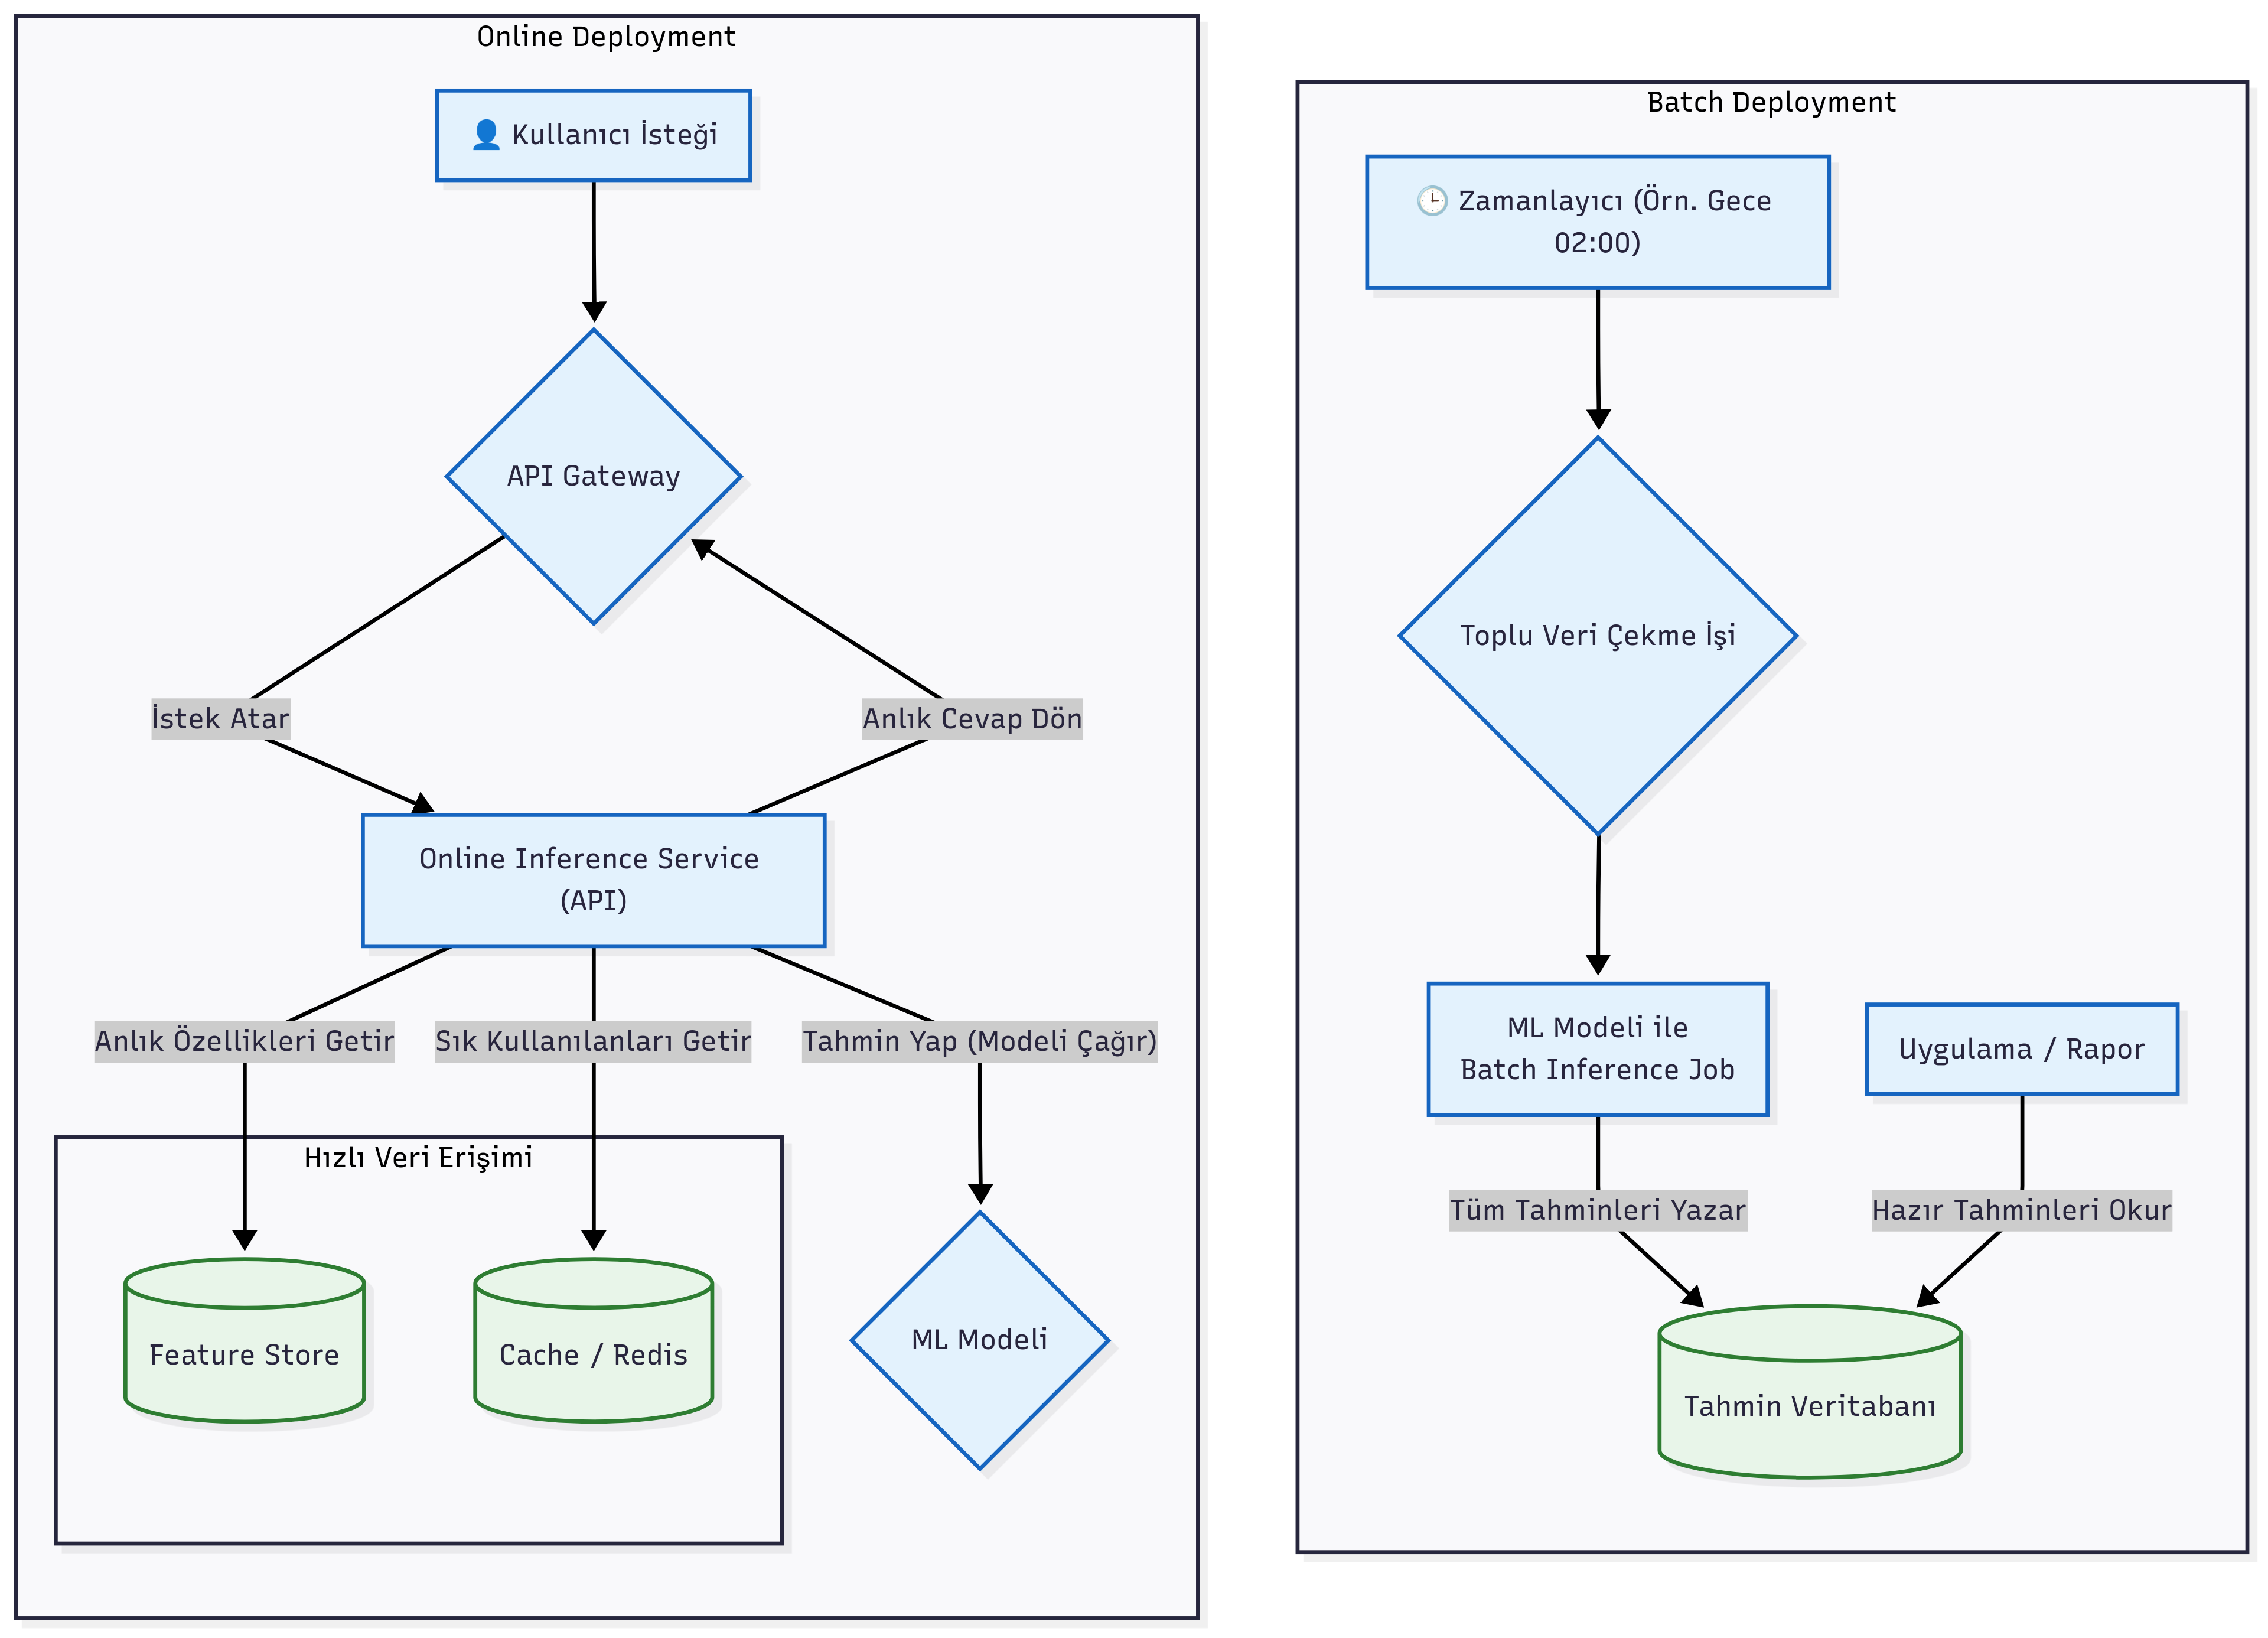

## 9. İzleme ve Geri Besleme

Bir modeli canlıya almak, yeni bir arabayı galeriden çıkarmak gibidir. Harika görünür ve iyi çalışır. Ancak onu düzenli olarak kontrol etmezseniz, yağını değiştirmezseniz veya benzinini doldurmazsanız, bir süre sonra yolda kalması kaçınılmazdır. **İzleme (Monitoring)**, modelimizin "gösterge panelidir". Bu panel, her şeyin yolunda gidip gitmediğini anlamamızı sağlar.

**Ana Fikir:** Modelin canlıdaki davranışı, eğitim sırasında gördüğümüzden farklılaşmaya başladığında bunu tespit etmeli ve aksiyon almalıyız. Bu sürece farklı isimler verilmektedir, en doğrusu `MLOps Feedback Loop`olarak isimlendirmektir.

### Ne İzlemeliyiz? <Monitoring>

Bir modelin sağlığını bütünsel olarak anlamak için farklı kategorilerde metrikleri izlememiz gerekir.

| Kategori | Metrik | Ne Ölçer? | Neden Kritik? |
|:---:|:---|:---|:---|
| **Model<br>Performansı** | AUC, F1-Skoru,<br>MAE, R² vb. | Modelin tahminlerinin doğruluğunu<br>ve iş hedefine hizmet edip<br>etmediğini ölçer. | **Model Çürümesi (Model Decay):**<br>Modelin performansı zamanla<br>kaçınılmaz olarak düşer. En<br>önemli alarm sinyalidir. |
| **Date<br>Drift** | **PSI** (Population<br>Stability Index),<br>KS Testi | Canlıda gelen verinin dağılımının,<br>modelin eğitildiği verinin<br>dağılımından ne kadar<br>uzaklaştığını ölçer. | Veri kayması, model performansının<br>düşmesinin en yaygın nedenidir.<br>Model, "bilmediği" bir dünyayla<br>karşılaşmaya başlamıştır. |
| **Teknik<br>Performans** | **Gecikme (Latency)**<br>**Hata Oranı** (Error Rate) | Sistemin teknik sağlığını ölçer.<br>Ne kadar hızlı cevap veriyor?<br>Ne sıklıkla çöküyor? | Yavaş veya kararsız bir sistem,<br>doğru tahmin yapsa bile kötü<br>kullanıcı deneyimi yaratır ve<br>güvenilirliğini yitirir. |
| **Operasyonel<br>Metrikler** | **Maliyet (Cost)** | Modelin çalışması için harcanan<br>bulut bilişim kaynağının<br>maliyetini ölçer. | Maliyetler kontrolden çıkarsa,<br>modelin getirdiği değer, götürdüğü<br>maliyetin altında kalabilir ve<br>proje sürdürülebilirliğini yitirir. |
| **Adillik<br>(Fairness)** | Gruplar Arası<br>TPR Farkı vb. | Modelin farklı kullanıcı<br>segmentlerine (örn. yaş, konum)<br>eşit ve adil davranıp<br>davranmadığını ölçer. | Yeni kullanıcı segmentleri ortaya<br>çıktıkça, modelin belirli gruplara<br>karşı yanlı (biased) davranmaya<br>başlamadığından emin olmalıyız. |

---

### Alarm Kuralları: Ne Zaman Endişelenmeliyiz?

Gösterge panelini 7/24 izlemek yerine, sadece önemli bir sorun olduğunda bizi uyaracak **otomatik alarmlar** kurarız. Bu alarmlar, basit eşiklerden daha akıllı olmalıdır.

**Kötü Alarm:** "AUC 0.80'in altına düşerse alarm ver."
*   *Neden Kötü?* Belki de yeni veriyle 0.80 zaten ulaşılamaz bir hedeftir. Statik eşikler yanıltıcı olabilir.

**İyi Alarm:** "AUC'nin 7 günlük hareketli ortalaması, önceki 30 günlük ortalamaya göre %5'ten fazla düşerse alarm ver."
*   **Neden İyi?**
    *   **Hareketli Ortalama:** Günlük rastgele dalgalanmaları (gürültüyü) yumuşatır ve gerçek trendi görmemizi sağlar.
    *   **Göreceli Düşüş:** Sabit bir eşik yerine, modelin kendi geçmiş performansına göre "anormal" bir düşüş olup olmadığını kontrol eder. Bu şekilde değişen koşullara çok daha iyi adapte olur.


> #### **Örnek Alarm Kuralı:**
>
> **Tetikleyici:** `AUC metriğinin 7 günlük hareketli ortalaması, bir önceki haftaya göre %5'ten daha fazla düştüğünde Yüksek Öncelikli bir alarm oluştur.`

---

### MLOps Feedback Loop - Alarm Verince Ne Yapmalıyız?

Bir alarm tetiklendiğinde, MLOps döngüsü yeniden başlar:

1.  **Analiz Et:** Sorun nedir? Performans mı düştü? Veri mi drift oldu? Teknik bir hata mı var?
2.  **Ana Neden Tespiti:** Data drift varsa, neden oldu? Yeni bir kampanya mı başladı? Rakipler bir değişiklik mi yaptı? Veri kaynağında bir hata mı var?
3.  **Aksiyon Al:**
    *   **Yeniden Eğit (Retrain):** En yaygın çözümdür. Modeli yeni ve güncel verilerle yeniden eğitmek, genellikle performansını geri kazandırır.
    *   **Geri Al (Rollback):** Eğer sorun yeni deploy edilen bir modelden kaynaklanıyorsa, hemen bir önceki stabil versiyona geri dönülür.
    *   **Modeli Değiştir:** Belki de Lojistik Regresyon artık yeterli değildir ve daha karmaşık bir modele (örn. Gradient Boosting) geçme zamanı gelmiştir.
4.  **Tekrarla:** Yeni çözüm canlıya alınır ve izleme süreci yeniden başlar.

## 10. Risk Kaydı

Bir ML projesi sadece kod ve veriden ibaret değildir; aynı zamanda yönetilmesi gereken belirsizlikler ve potansiyel sorunlar bütünüdür. Risk Kaydı, bu riskleri proaktif bir şekilde yönetmek için kullanılan canlı bir dokümandır. Amacı:
 *  `Umarım bu sorunla karşılaşmayız` demek yerine,
 * `Eğer bu sorunla karşılaşırsak, planımız budur`

diyebilmektir.


---

### Risk Kaydı Tablosunun Anatomisi

Risk kaydı, genellikle aşağıdaki sütunları içeren bir tablodur:

| Sütun | Açıklama |
|:---|:---|
| **ID veya İsim** | Riskleri tanımlamak için. |
| **Risk Açıklama** | Potansiyel sorunun kısa ve net tanımı. |
| **Olasılık** | Riskin gerçekleşme ihtimali (Düşük, Orta, Yüksek). |
| **Etki** | Risk gerçekleşirse, proje üzerindeki olumsuz etkisinin büyüklüğü (Düşük, Orta, Yüksek). |
| **Çözüm (Mitigation)** | Riskin gerçekleşmesini önlemek veya etkisini düşürmek için alınacak önlemler ve aksiyon planları. |
| **Durum** | Riskin mevcut durumu (Açık, Kapalı, İzleniyor). |

---


## 11. Proje İskeleti ve Dosya Düzeni

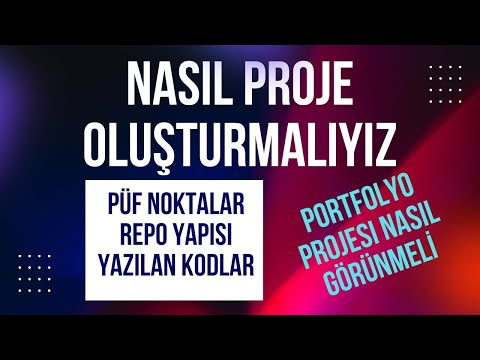

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("Lz0dZpPQo_8", 1000, 600)

In [ ]:
base = pathlib.Path('/mnt/data/ml_modul1_proje_iskeleti_fmt')
for d in ['data/raw','data/processed','notebooks','models','reports/figures','src/features','src/models','src/utils','configs','tests']:
    (base/d).mkdir(parents=True, exist_ok=True)
(base/'README.md').write_text("# Proje İskeleti (Modül 1)\n", encoding='utf-8')

tree = []
for p in base.rglob('*'):
    tree.append(str(p.relative_to(base)))
tree_df = pd.DataFrame(tree, columns=["İskelet"])
display(tree_df.style.hide(axis="index"))

İskelet
notebooks
data
reports
configs
models
README.md
src
tests
data/processed
data/raw


## 12. Mini Uçtan Uca Örnek (Kabul Kriteri Kontrolü)

In [ ]:
target_metric = "F1"
target_threshold = 0.75

X, y = make_classification(n_samples=1000, n_features=10, random_state=RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

majority = int(pd.Series(y_train).mode()[0])
y_pred_base = np.full_like(y_test, fill_value=majority)
f1_base = f1_score(y_test, y_pred_base)

pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
pipe.fit(X_train, y_train)
f1_model = f1_score(y_test, pipe.predict(X_test))

result = pd.DataFrame([
    ["Baseline F1", round(f1_base,3)],
    ["Model F1", round(f1_model,3)],
    ["Kabul (>=0.75)?", "EVET" if f1_model >= target_threshold else "HAYIR"]
], columns=["Öğe","Değer"])
display(result.style.hide(axis="index"))

Öğe,Değer
Baseline F1,0.000000
Model F1,0.821000
Kabul (>=0.75)?,EVET
